<a href="https://colab.research.google.com/github/mernaelshawa8/Computer-Vision-/blob/main/LaneDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

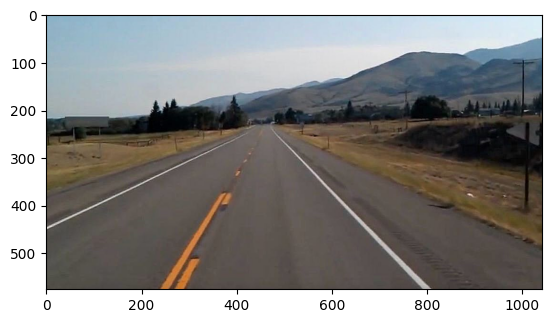

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
# Load Image
img_path=  r"C:\Users\Merna\Desktop\image5.jpg"
img = cv2.imread(img_path)\
# Convert to RGB (OpenCV uses BGR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Display image
plt.imshow(img_rgb)

## Preprocessing


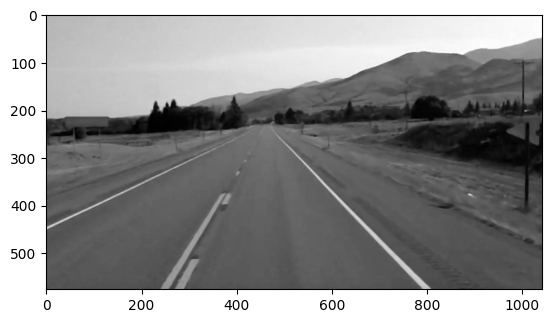

In [ ]:
#converts from BGR to gray scale
image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Apply Median Blur
image = cv2.medianBlur(image, 5)
# Display image
plt.imshow(image, cmap='gray')

# Edge Detection

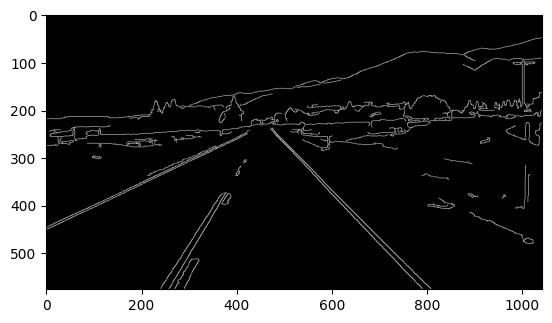

In [ ]:
# Use the Canny function to detect edges in the image
edges = cv2.Canny(image, 30, 150)  # 30 and 200 are the lower and upper thresholds for hysteresis
# Display the image
plt.imshow(edges, cmap='gray')

# ROI

Text(0.5, 1.0, 'Masked Image')

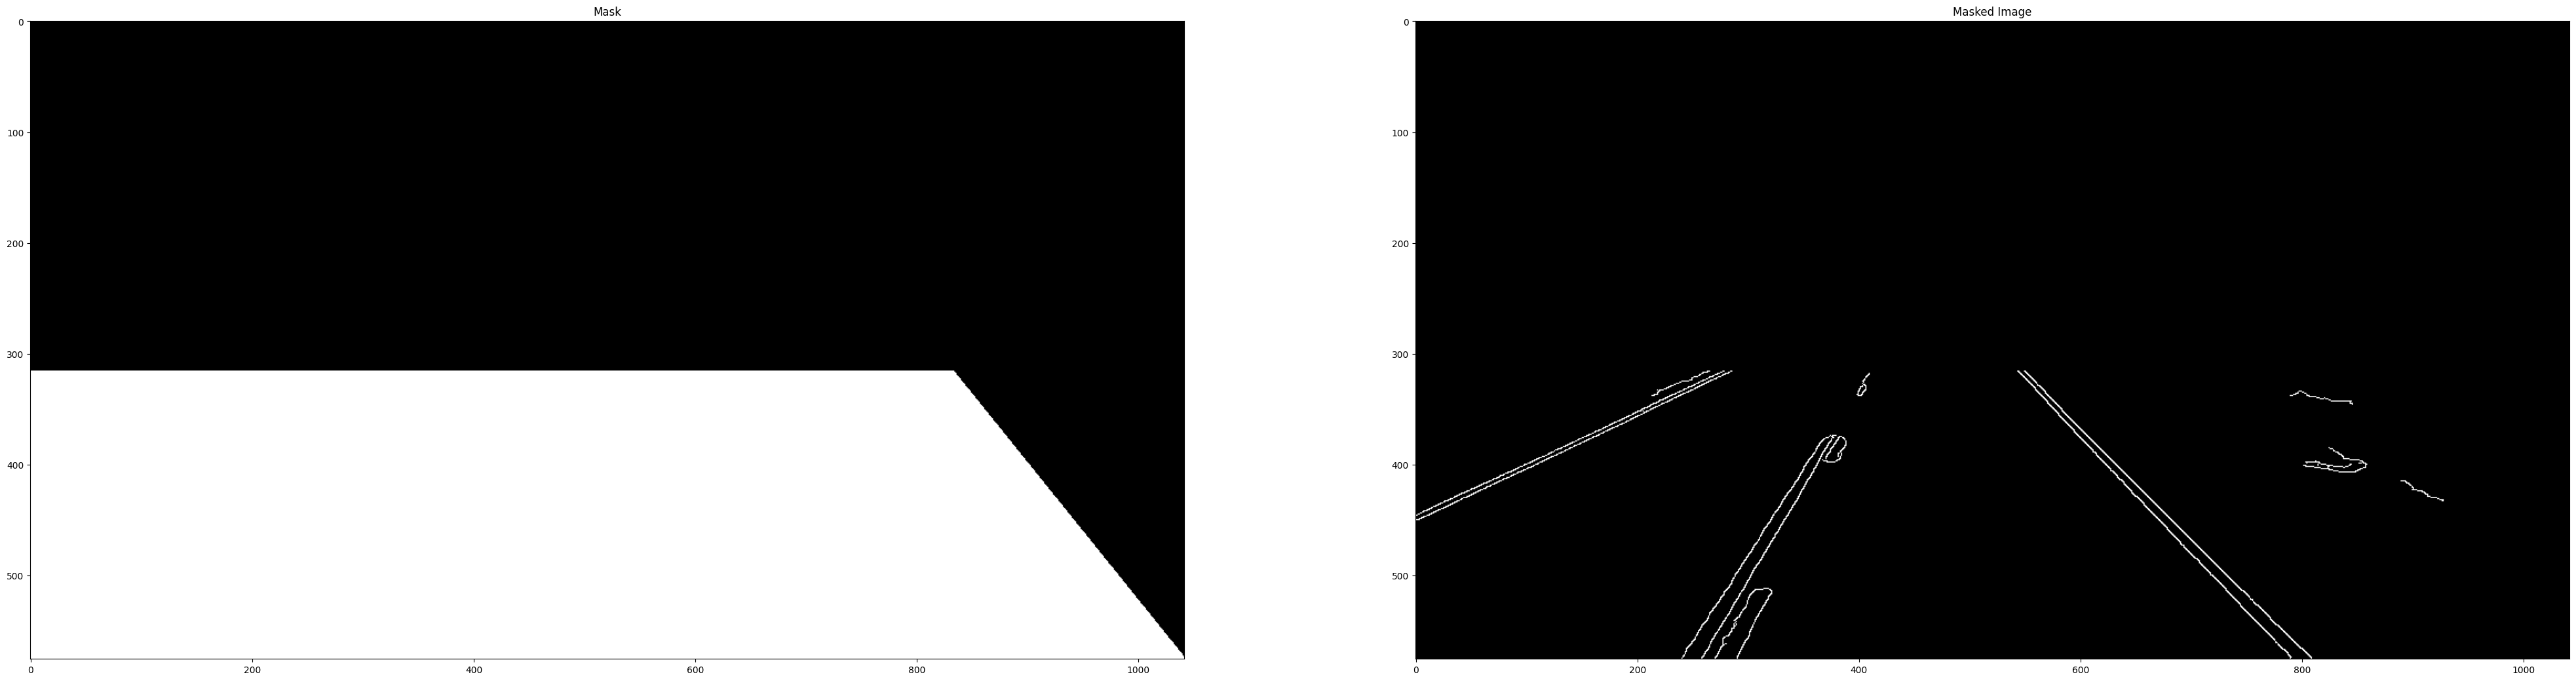

In [ ]:
height, width = image.shape[:2]


# Define a trapezoidal region of interest (adjust points as needed)
roi_vertices = np.array([[
    (int(0* width), height),  # Bottom-left
    (int(0. * width), int(0.55 * height)),  # Top-left
    (int(0.8 * width), int(0.55 * height)),  # Top-right
    (int(1* width), height)  # Bottom-right
]], dtype=np.int32)

# Create a black mask with the same size as the image
mask = np.zeros_like(image)
# Fill ROI with white
cv2.fillPoly(mask, roi_vertices, 255)

# Apply the mask
masked_image = cv2.bitwise_and(edges, mask)
plt.figure(figsize=(50, 50))

#  Display the image
plt.subplot(1,2,1)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.subplot(1,2,2)
plt.imshow(masked_image, cmap='gray')
plt.title('Masked Image')


# Hough Transform for Line Detection


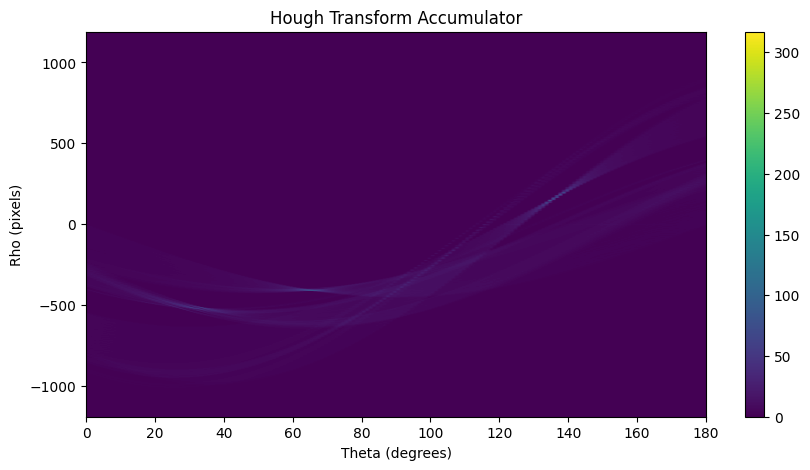

In [ ]:
height, width = masked_image.shape
# Diagonal length of the image, which is the longest distance between any two points.
diag_len = int(np.sqrt(width ** 2 + height ** 2))
# Range of angles to be considered
thetas = np.deg2rad(np.arange(0, 180))
rhos = np.arange(-diag_len, diag_len) #range of rohs to be considered

#Accumulator at first set to zeros
H = np.zeros((len(rhos), len(thetas)), dtype=np.int64)

# Loop through each edge point
y_indices, x_indices = np.nonzero(masked_image)
for x, y in zip(x_indices, y_indices):
    for theta_idx in range(len(thetas)):
        theta = thetas[theta_idx]
        # Calculate rho
        rho = int(x * np.cos(theta) + y * np.sin(theta)) + diag_len  # Shift rho to be non-negative
        H[rho, theta_idx] += 1  #vote for the line

plt.figure(figsize=(10, 5))
plt.imshow(H, cmap='viridis', extent=[0, 180, -H.shape[0]//2, H.shape[0]//2], aspect='auto')
plt.title(f'Hough Transform Accumulator')
plt.xlabel('Theta (degrees)')
plt.ylabel('Rho (pixels)')
plt.colorbar()
plt.show()


# Non-Maximum Supression

Number of strong lines detected: 13


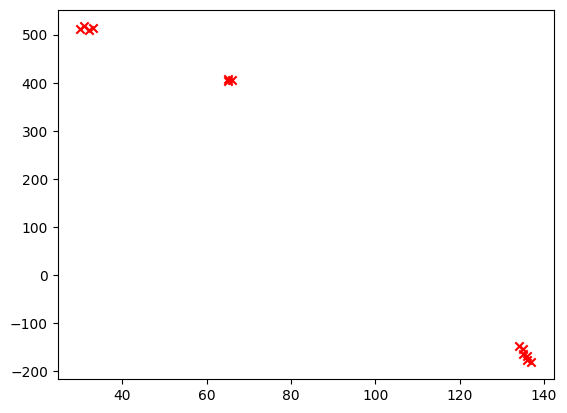

In [ ]:
suppressed_H = np.zeros_like(H)
# Apply maximum filter to find local maxima
local_max = maximum_filter(H, size=3) == H

# Apply threshold to suppress weak lines
threshold = 0.3 * np.max(H)
suppressed_H = np.where((H >= threshold) & local_max, H, 0)

# Overlay the detected peaks
# Find the indices of the strongest lines in the suppressed_H accumulator
strong_lines = np.argwhere(suppressed_H > 0)
print(f"Number of strong lines detected: {len(strong_lines)}")
for rho_idx, theta_idx in strong_lines:
    rho = rhos[rho_idx]
    theta = np.rad2deg(thetas[theta_idx])
    plt.scatter(theta, rho, color='red', marker='x')  # Mark detected peaks


# Displaying with lines

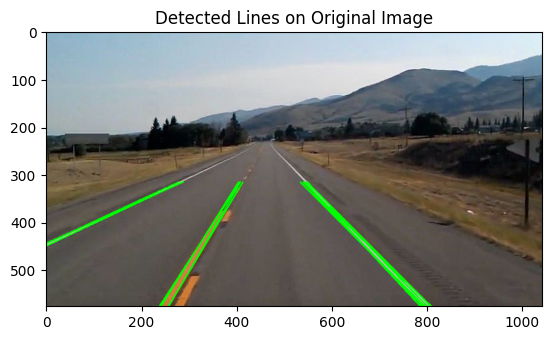

In [ ]:
# Create a copy of the original RGB image to draw lines on
output_image = img_rgb.copy()

# Flatten the roi_vertices array to 2D
roi_vertices_2d = roi_vertices.reshape(-1, 2)

# Loop through the strong lines and draw them
for rho_idx, theta_idx in strong_lines:
    rho = rhos[rho_idx]  # Shift rho back to its original range
    theta = thetas[theta_idx]
    # print(f"Detected line: rho = {rho}, theta = {theta} degrees")

    # Convert polar coordinates to Cartesian coordinates
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))  # Extend the line
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))

    # Find intersections of the line with the ROI polygon
    intersections = []
    for i in range(len(roi_vertices_2d)):
        x3, y3 = roi_vertices_2d[i]
        x4, y4 = roi_vertices_2d[(i + 1) % len(roi_vertices_2d)]  # Wrap around

        # Compute intersection using line equations
        denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        if denom == 0:
            continue  # Lines are parallel, no intersection

        t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denom
        u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denom

        if 0 <= t <= 1 and 0 <= u <= 1:
            intersect_x = int(x1 + t * (x2 - x1))
            intersect_y = int(y1 + t * (y2 - y1))
            intersections.append((intersect_x, intersect_y))

    # If exactly two intersection points are found, draw the clipped line
    if len(intersections) == 2:
        cv2.line(output_image, intersections[0], intersections[1], (0, 255, 0), 2)  # Green color, thickness=2

# Display the result
plt.imshow(output_image)
plt.title('Detected Lines on Original Image')
plt.show()


# # Loop through the strong lines and draw them
# for rho_idx, theta_idx in strong_lines:
#     rho = rhos[rho_idx]  # Shift rho back to its original range
#     theta = thetas[theta_idx]
#     print(f"Detected line: rho = {rho}, theta = {theta} degrees")
#     # Convert polar coordinates to Cartesian coordinates
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a * rho
#     y0 = b * rho
#     x1 = int(x0 + 1000 * (-b))  # Extend the line
#     y1 = int(y0 + 1000 * (a))
#     x2 = int(x0 - 1000 * (-b))
#     y2 = int(y0 - 1000 * (a))

#     # Draw the line on the output image
#     cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green color, thickness=2

# # Display the result
# plt.imshow(output_image)
# plt.title('Detected Lines on Original Image')
# plt.show()